# 1. Data Preparation

### Read in data

In [0]:
dbutils.fs.ls("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet")

Out[1]: [FileInfo(path='abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/comments/', name='comments/', size=0, modificationTime=1666557328000),
 FileInfo(path='abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/submissions/', name='submissions/', size=0, modificationTime=1666559745000)]

In [0]:
comments = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/comments")

### Filter out the number of posts with untrackable authors<br>
#### (Might due to user cancellation or user-deletion of the post)

In [0]:
from pyspark.sql.functions import col

deleted = comments.filter(col("subreddit") == "AskReddit").filter(col("author") == "[deleted]")
print(deleted.count())
deleted.show(5)

12913089
+---------+--------------+----------------------+-----------------+---------+--------+----------------+-----------+-------------+-------------+------+-------+------------+---------+----------+--------------------+------------+-----+--------+---------+------------+
|   author|author_cakeday|author_flair_css_class|author_flair_text|     body|can_gild|controversiality|created_utc|distinguished|       edited|gilded|     id|is_submitter|  link_id| parent_id|           permalink|retrieved_on|score|stickied|subreddit|subreddit_id|
+---------+--------------+----------------------+-----------------+---------+--------+----------------+-----------+-------------+-------------+------+-------+------------+---------+----------+--------------------+------------+-----+--------+---------+------------+
|[deleted]|          null|                  null|             null|[deleted]|    true|               0| 1624437160|         null|1.624437343E9|     0|h2qxm7z|       false|t3_o5n00e| t3_o5n00e|/r/A

In [0]:
askreddit = comments.filter(col("subreddit") == "AskReddit")
askreddit.write.mode('Overwrite').parquet('dbfs:/FileStore/comments_askreddit.parquet')

In [0]:
comment_ar = spark.read.parquet('dbfs:/FileStore/comments_askreddit.parquet')

### Filter out the actual cancelled users, randomly sample similar number of trackable posts to balance the dataset

In [0]:
deleted_user = comment_ar.filter((col("author") == "[deleted]") & (col("body") != "[deleted]"))
print(deleted_user.count())
not_deleted = comment_ar.filter(col("body") != "[deleted]").sample(fraction = 6893622/(comment_ar.count()-6893622), seed = 685)
print(not_deleted.count())

6893622
6944850


In [0]:
sampled = deleted_user.union(not_deleted)
sampled.count()

Out[7]: 13838472

### Remove useless columns, add feature for removed-by-mod posts, then separate them temporarily
#### (Since their bodies are plainly [removed], useless for sentiment analysis and keyword extraction)

In [0]:
from pyspark.sql.functions import *

sampled_new = sampled.drop('author_cakeday','author_flair_css_class','author_flair_text','can_gild','distinguished','retrieved_on','id','link_id','parent_id','permalink','subreddit','subreddit_id').dropna()
sampled_new = sampled_new.withColumn("removed_by_mod", col("body") == "[removed]")
sampled_new_2021 = sampled_new.filter(year(from_unixtime(col('created_utc'))) == 2021)
sampled_not_removed = sampled_new_2021.filter(col("removed_by_mod") == False)
sampled_removed = sampled_new_2021.filter(col("removed_by_mod") == True)

### Text preprocessing, making the body column ready for TF-IDF and sentiment model

In [0]:
from sparknlp.base import Finisher
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col

documentAssembler = DocumentAssembler() \
.setInputCol("body") \
.setOutputCol("document")

sentenceDetector = SentenceDetector() \
.setInputCols(["document"]) \
.setOutputCol("sentence")

tokenizer = Tokenizer() \
.setInputCols(["sentence"]) \
.setOutputCol("token")

stop_words = StopWordsCleaner() \
.setInputCols(["token"]) \
.setOutputCol("cleanTokens")

pipeline = PretrainedPipeline("check_spelling", "en")

lemmatizer = LemmatizerModel.pretrained() \
.setInputCols(["cleanTokens"]) \
.setOutputCol("lemma")

normalizer = Normalizer() \
.setInputCols(["lemma"]) \
.setOutputCol("normal") \
.setLowercase(True) \
.setCleanupPatterns([("""[^A-Za-z]""")])

tokenAssembler = TokenAssembler() \
.setInputCols("document", "normal") \
.setOutputCol("cleanText")

embedding = WordEmbeddingsModel.pretrained() \
.setInputCols(["document","normal"]) \
.setOutputCol("embeddings")

embeddingsFinisher = EmbeddingsFinisher() \
.setInputCols("embeddings") \
.setOutputCols("finished_sentence_embeddings") \
.setOutputAsVector(True) \
.setCleanAnnotations(False)  \

finisher = Finisher() \
     .setInputCols(['normal',"cleanText"])

pipeline = Pipeline() \
.setStages([
documentAssembler,
sentenceDetector,
tokenizer,
stop_words,
lemmatizer,
normalizer,
tokenAssembler,
embedding,
embeddingsFinisher,
finisher
])

result_token = pipeline.fit(sampled_not_removed).transform(sampled_not_removed)
result_token.show()

check_spelling download started this may take some time.
Approx size to download 913.5 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
+---------+--------------------+----------------+-----------+-------------+------+------------+-----+--------+--------------+----------------------------+--------------------+--------------------+
|   author|                body|controversiality|created_utc|       edited|gilded|is_submitter|score|stickied|removed_by_mod|finished_sentence_embeddings|     finished_normal|  finished_cleanText|
+---------+--------------------+----------------+-----------+-------------+------+------------+-----+--------+--------------+----------------------------+--------------------+--------------------+
|[deleted]|Ha. Probably a so...|               0| 1613891403|        false|     0|       false|    1|   false|       

In [0]:
sampled_just_deleted = sampled_not_removed.filter((col("author") == "[deleted]") & (col("body") != "[removed]"))

pipeline_2 = Pipeline() \
.setStages([
documentAssembler,
sentenceDetector,
tokenizer,
stop_words,
lemmatizer,
normalizer,
tokenAssembler,
embedding,
embeddingsFinisher,
finisher
])

result_token_deleted = pipeline_2.fit(sampled_just_deleted).transform(sampled_just_deleted)

### TF-IDF

In [0]:
from pyspark.ml.feature import CountVectorizer, IDF
tfizer = CountVectorizer(inputCol='finished_normal',
                         outputCol='tf_features')
tf_model = tfizer.fit(result_token_deleted)
tf_result = tf_model.transform(result_token_deleted)
idfizer = IDF(inputCol='tf_features', 
              outputCol='tf_idf_features')
idf_model = idfizer.fit(tf_result)
tfidf_result_2021 = idf_model.transform(tf_result)

In [0]:
vocabList = tf_model.vocabulary

In [0]:
from pyspark.ml.functions import vector_to_array

tfidf_2021_c = tfidf_result_2021.select('tf_idf_features')
# create two new colnum
tfidf_2021_c = tfidf_2021_c.withColumn("array",vector_to_array("tf_idf_features"))\
.withColumn("max_index_col",F.expr("array_position(array,array_max(array))"))
# count frequency
key_word_index_2021 = tfidf_2021_c.groupBy('max_index_col').count().orderBy(col("count"), ascending=False)

In [0]:
from pyspark.sql.functions import udf
def vocab(i):
    return vocabList[i]
udf_word = udf(lambda x:vocab(x))
key_word_index_2021 = key_word_index_2021.withColumn("word",udf_word(col("max_index_col")))
key_word_index_2021.show(30)

+-------------+-----+--------+
|max_index_col|count|    word|
+-------------+-----+--------+
|            1|54063|     get|
|           90| 5310| nothing|
|           58| 4770|    fuck|
|          176| 4244|       s|
|          119| 3240|  change|
|          448| 3140|  likely|
|          270| 3088|   enjoy|
|           40| 2989|    back|
|          146| 2889| another|
|           59| 2860|actually|
|          396| 2759|  moment|
|          174| 2748|    hour|
|          206| 2605|interest|
|           85| 2584|      we|
|          208| 2517|    next|
|          148| 2498|   wrong|
|          416| 2415|  follow|
|          122| 2384|    hate|
|           21| 2366|   never|
|           28| 2315|     its|
|          218| 2306|    face|
|           11| 2303|   thing|
|           91| 2275|    help|
|          225| 2273|   issue|
|          192| 2248|    hand|
|           48| 2196|    find|
|          347| 2193|    dick|
|           82| 2163|   watch|
|          423| 2157|    self|
|       

### Manually extract 10 keywords from the top 30 common words for feature engeneering

In [0]:
common_deleted_words = ['nothing', 'fuck','interest','wrong','follow','hate','never','face','issue','dick']


In [0]:
st_df = result_token.withColumn("cleanText", result_token["finished_cleanText"].getItem(0))
st_df.select("finished_normal").show()

+--------------------+
|     finished_normal|
+--------------------+
|[ha, probably, so...|
|[child, escape, b...|
|[post, go, nonsen...|
|[joker, either, h...|
|[fun, fact, hitle...|
|[thing, think, co...|
|[guy, dead, wife,...|
|[idea, alive, fee...|
|[scared, movie, n...|
|         [entire, s]|
|[say, man, certai...|
|[well, s, legal, ...|
|    [hang, kid, day]|
|[omgosh, feel, ba...|
|[think, nosedivin...|
|[im, straight, ha...|
| [mean, x, shoulder]|
|[cross, stitch, n...|
|[well, understand...|
|[respect, elder, ...|
+--------------------+
only showing top 20 rows



### Generate new boolean feature of body containing any of the 10 keywords above

In [0]:
from pyspark.sql.functions import arrays_overlap, array
import pyspark.sql.functions as F

st_df = st_df.withColumn("common_deleted_words", F.array([F.lit(x) for x in common_deleted_words]))
st_df = st_df.withColumn("contain_often_deleted_words", arrays_overlap(st_df.finished_normal, st_df.common_deleted_words))
st_df.show()

+---------+--------------------+----------------+-----------+-------------+------+------------+-----+--------+--------------+----------------------------+--------------------+--------------------+--------------------+--------------------+---------------------------+
|   author|                body|controversiality|created_utc|       edited|gilded|is_submitter|score|stickied|removed_by_mod|finished_sentence_embeddings|     finished_normal|  finished_cleanText|           cleanText|common_deleted_words|contain_often_deleted_words|
+---------+--------------------+----------------+-----------+-------------+------+------------+-----+--------+--------------+----------------------------+--------------------+--------------------+--------------------+--------------------+---------------------------+
|[deleted]|Ha. Probably a so...|               0| 1613891403|        false|     0|       false|    1|   false|         false|        [[-0.215680003166...|[ha, probably, so...|[ha probably soli...|ha 

### Deploy sentiment model to analyze the sentiment of body texts

In [0]:
import sparknlp
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline

In [0]:
# Define Spark NLP pipleline
documentAssembler = DocumentAssembler()\
    .setInputCol("cleanText")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = SentimentDLModel.pretrained(name='sentimentdl_use_twitter', lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


In [0]:
# Run the pipeline
pipelineModel = nlpPipeline.fit(st_df)
st_result = pipelineModel.transform(st_df)
# drop redundant columns
st_result = st_result.drop('finished_cleanText','document','sentence_embeddings','common_deleted_words')
# Pull out the sentiment output into its own column in the main dataframe
st_result=st_result.withColumn('sentiment_class', F.concat_ws('',col('sentiment.result')))
st_result.show()

+---------+--------------------+----------------+-----------+-------------+------+------------+-----+--------+--------------+----------------------------+--------------------+--------------------+---------------------------+--------------------+---------------+
|   author|                body|controversiality|created_utc|       edited|gilded|is_submitter|score|stickied|removed_by_mod|finished_sentence_embeddings|     finished_normal|           cleanText|contain_often_deleted_words|           sentiment|sentiment_class|
+---------+--------------------+----------------+-----------+-------------+------+------------+-----+--------+--------------+----------------------------+--------------------+--------------------+---------------------------+--------------------+---------------+
|[deleted]|Ha. Probably a so...|               0| 1613891403|        false|     0|       false|    1|   false|         false|        [[-0.215680003166...|[ha, probably, so...|ha probably solid...|                  

### Mark removed posts with unknown sentiment and keyword, then assemble them back to form data for ML

In [0]:
st_result_ml = st_result.withColumn("deleted", (col("author") == "[deleted]") & (col("body") != "[deleted]"))
st_result_ml = st_result_ml.drop('author','body','created_utc','finished_sentence_embeddings','finished_normal','cleanText','sentiment')
st_result_ml.printSchema()

root
 |-- controversiality: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- removed_by_mod: boolean (nullable = true)
 |-- contain_often_deleted_words: boolean (nullable = true)
 |-- sentiment_class: string (nullable = false)
 |-- deleted: boolean (nullable = true)



In [0]:
sampled_removed_final = sampled_removed.withColumn("contain_often_deleted_words", lit("unknown"))
sampled_removed_final = sampled_removed_final.withColumn("sentiment_class", lit("unknown"))
sampled_removed_final = sampled_removed_final.withColumn("deleted", (col("author") == "[deleted]") & (col("body") != "[deleted]"))
sampled_removed_final = sampled_removed_final.drop('author','body','created_utc')
sampled_removed_final.printSchema()

root
 |-- controversiality: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- removed_by_mod: boolean (nullable = true)
 |-- contain_often_deleted_words: string (nullable = false)
 |-- sentiment_class: string (nullable = false)
 |-- deleted: boolean (nullable = true)



#### Preprocessing column types to make them ready for ML pipeline

In [0]:
from pyspark.sql.types import StringType,BooleanType,DateType

st_result_final = st_result_ml.withColumn("contain_often_deleted_words",col("contain_often_deleted_words").cast(StringType()))
ml_df = st_result_final.union(sampled_removed_final)
ml_df.show()

+----------------+-------------+------+------------+-----+--------+--------------+---------------------------+---------------+-------+
|controversiality|       edited|gilded|is_submitter|score|stickied|removed_by_mod|contain_often_deleted_words|sentiment_class|deleted|
+----------------+-------------+------+------------+-----+--------+--------------+---------------------------+---------------+-------+
|               0|        false|     0|       false|    1|   false|         false|                      false|       positive|   true|
|               0|        false|     0|       false|    1|   false|         false|                      false|       positive|   true|
|               0|        false|     0|       false|    1|   false|         false|                      false|       negative|   true|
|               0|        false|     0|       false|   12|   false|         false|                      false|       positive|   true|
|               0|        false|     0|       false|   

In [0]:
ml_df.groupBy("edited").count().show()

+-------------+-----+
|       edited|count|
+-------------+-----+
|1.627451697E9|    1|
|1.625123141E9|    1|
|1.628954305E9|    1|
|1.626848328E9|    1|
|1.627105052E9|    1|
|1.630139698E9|    1|
| 1.61361512E9|    1|
|1.613895115E9|    1|
|1.629847015E9|    1|
|1.618272996E9|    1|
|1.617602291E9|    3|
|1.630322909E9|    1|
|1.630034377E9|    1|
|1.632779347E9|    1|
|1.619923146E9|    1|
|1.628999299E9|    1|
|1.626675393E9|    1|
|1.631544979E9|    1|
|1.631111373E9|    1|
|1.627389404E9|    1|
+-------------+-----+
only showing top 20 rows



In [0]:
ml_df = ml_df.withColumn("edited", when(ml_df.edited == "false" ,False).otherwise(True))

In [0]:
ml_df.printSchema()

root
 |-- controversiality: long (nullable = true)
 |-- edited: boolean (nullable = false)
 |-- gilded: long (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- removed_by_mod: boolean (nullable = true)
 |-- contain_often_deleted_words: string (nullable = true)
 |-- sentiment_class: string (nullable = false)
 |-- deleted: boolean (nullable = true)



In [0]:
from pyspark.sql.types import *

ml_df = ml_df.withColumn("controversiality", col("controversiality").cast(IntegerType())).withColumn("gilded", col("gilded").cast(IntegerType()))
ml_df.printSchema()

root
 |-- controversiality: integer (nullable = true)
 |-- edited: boolean (nullable = false)
 |-- gilded: integer (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- removed_by_mod: boolean (nullable = true)
 |-- contain_often_deleted_words: string (nullable = true)
 |-- sentiment_class: string (nullable = false)
 |-- deleted: boolean (nullable = true)



In [0]:
ml_df.write.mode('Overwrite').parquet('dbfs:/FileStore/askreddit_delete_data.parquet')

# 2. Machine Learning Stage

In [0]:
from pyspark.sql.functions import *

ml_data = spark.read.parquet('dbfs:/FileStore/askreddit_delete_data.parquet')
ml_data = ml_data.withColumn("deleted", col("deleted").cast(StringType()))
ml_data = ml_data.filter(col("sentiment_class") != "")

### Split the dataset into train, test and prediction set

In [0]:
train_data, test_data, predict_data = ml_data.randomSplit([0.8, 0.18, 0.02], 685)
print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))
print("Number of prediction records : " + str(predict_data.count()))

Number of training records: 6964917
Number of testing records : 1566958
Number of prediction records : 174197


### Setup the ML pipeline
#### data->indexer->encoder->vectorAssembler->Model->labelConverter->result dataframe

#### 1. Random forest

In [0]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [0]:
stringIndexer_deleted = StringIndexer(inputCol="deleted", outputCol="delete_status")
stringIndexer_common = StringIndexer(inputCol="contain_often_deleted_words", outputCol="sensitive_words")
stringIndexer_sentiment = StringIndexer(inputCol="sentiment_class", outputCol="sentiment")

In [0]:
onehot_common = OneHotEncoder(inputCol="sensitive_words", outputCol="sensitive_words_vec")
onehot_sentiment = OneHotEncoder(inputCol="sentiment", outputCol="sentiment_vec")
vectorAssembler_features = VectorAssembler(
    inputCols=["controversiality", "edited","gilded","is_submitter","score","stickied","removed_by_mod","sensitive_words_vec","sentiment_vec"], 
    outputCol= "features")

In [0]:
rf = RandomForestClassifier(labelCol="delete_status", featuresCol="features", numTrees=50)

In [0]:
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedDeletedStatus", 
                               labels= ["Account_deleted","Account_alive"])

In [0]:
pipeline_rf = Pipeline(stages=[stringIndexer_deleted, 
                               stringIndexer_common, 
                               stringIndexer_sentiment,  
                               onehot_common,
                               onehot_sentiment,
                               vectorAssembler_features, 
                               rf, labelConverter])

In [0]:
model_rf = pipeline_rf.fit(train_data)
pred_train = model_rf.transform(train_data)
pred_train.take(10)

Out[37]: [Row(controversiality=0, edited=False, gilded=0, is_submitter=False, score=-462, stickied=False, removed_by_mod=False, contain_often_deleted_words='false', sentiment_class='negative', deleted='false', delete_status=1.0, sensitive_words=0.0, sentiment=1.0, sensitive_words_vec=SparseVector(2, {0: 1.0}), sentiment_vec=SparseVector(3, {1: 1.0}), features=SparseVector(12, {4: -462.0, 7: 1.0, 10: 1.0}), rawPrediction=DenseVector([23.7352, 26.2648]), probability=DenseVector([0.4747, 0.5253]), prediction=1.0, predictedDeletedStatus='Account_alive'),
 Row(controversiality=0, edited=False, gilded=0, is_submitter=False, score=-209, stickied=False, removed_by_mod=False, contain_often_deleted_words='false', sentiment_class='positive', deleted='false', delete_status=1.0, sensitive_words=0.0, sentiment=0.0, sensitive_words_vec=SparseVector(2, {0: 1.0}), sentiment_vec=SparseVector(3, {0: 1.0}), features=SparseVector(12, {4: -209.0, 7: 1.0, 9: 1.0}), rawPrediction=DenseVector([23.8189, 26.1811

In [0]:
predictions = model_rf.transform(test_data)
evaluatorRF = MulticlassClassificationEvaluator(labelCol="delete_status", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions)
print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.648448
Test Error = 0.351552


That's already a good prediction accuracy. But can we learn further from feature importances?

In [0]:
model_rf.stages[-2].featureImportances

Out[39]: SparseVector(12, {0: 0.0001, 1: 0.0002, 2: 0.0, 3: 0.0221, 4: 0.0029, 5: 0.0006, 6: 0.2522, 7: 0.058, 8: 0.3299, 9: 0.015, 10: 0.0117, 11: 0.3073})

In [0]:
import pandas as pd
import os

PLOT_DIR = os.path.join("..","..","data", "plots", "ml_analysis_2")
CSV_DIR = os.path.join("..","..","data", "csv", "ml_analysis_2")

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))
importance_rf = ExtractFeatureImp(model_rf.stages[-2].featureImportances, model_rf.transform(train_data), "features")

In [0]:
importance_rf

,idx,name,score
8,8,sensitive_words_vec_unknown,0.329943
11,11,sentiment_vec_unknown,0.307259
6,6,removed_by_mod,0.252235
7,7,sensitive_words_vec_false,0.058031
3,3,is_submitter,0.022109
9,9,sentiment_vec_positive,0.015030
10,10,sentiment_vec_negative,0.011701
4,4,score,0.002872
5,5,stickied,0.000566
1,1,edited,0.000189


Here we can see the removed-or-not features are the most important for user-cancellation. Maybe the users getting cancelled usually post inappropriate contents and cancellation is one of the final punishment by the Reddit moderators.

### 2. Linear support vector machine

In [0]:
svm = LinearSVC(labelCol="delete_status", featuresCol="features")
pipeline_svm = Pipeline(stages=[stringIndexer_deleted, 
                               stringIndexer_common, 
                               stringIndexer_sentiment,  
                               onehot_common,
                               onehot_sentiment,
                               vectorAssembler_features, 
                               svm, labelConverter])
model_svm = pipeline_svm.fit(train_data)
predictions_svm = model_svm.transform(test_data)
evaluatorRF = MulticlassClassificationEvaluator(labelCol="delete_status", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions_svm)
print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.648467
Test Error = 0.351533


Similar accuracy.

### 3. Gradient boosting trees

In [0]:
gbt = GBTClassifier(labelCol="delete_status", featuresCol="features", maxIter=10)
pipeline_gbt = Pipeline(stages=[stringIndexer_deleted, 
                               stringIndexer_common, 
                               stringIndexer_sentiment,  
                               onehot_common,
                               onehot_sentiment,
                               vectorAssembler_features, 
                               gbt, labelConverter])
model_gbt = pipeline_gbt.fit(train_data)
predictions_gbt = model_gbt.transform(test_data)
evaluator_gbt = MulticlassClassificationEvaluator(labelCol="delete_status", predictionCol="prediction", metricName="accuracy")
accuracy_gbt = evaluator_gbt.evaluate(predictions_gbt)
print("Accuracy = %g" % accuracy_gbt)
print("Test Error = %g" % (1.0 - accuracy_gbt))

Accuracy = 0.650444
Test Error = 0.349556


This one has a bit higher accuracy than the previous 2, but other metrics still need to be evaluated for further comparison.

In [0]:
evaluator_ac = MulticlassClassificationEvaluator(labelCol="delete_status", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="delete_status", predictionCol="prediction", metricName="f1")
evaluator_roc = BinaryClassificationEvaluator(labelCol="delete_status", rawPredictionCol="prediction", metricName="areaUnderROC")

In [0]:
perf_ac = []
perf_f1 = []
perf_roc = []
for model in [model_rf, model_svm, model_gbt]:
    predictions = model.transform(test_data)
    perf_ac.append(evaluator_ac.evaluate(predictions))
    perf_f1.append(evaluator_f1.evaluate(predictions))
    perf_roc.append(evaluator_roc.evaluate(predictions))
model_performances = pd.DataFrame(list(zip(perf_ac,perf_f1,perf_roc)), index = ["rf","svm","gbt"], columns=["accuracy","f1_score","ROC_area"])
model_performances

,accuracy,f1_score,ROC_area
rf,0.648448,0.617113,0.683921
svm,0.648467,0.617802,0.683616
gbt,0.650444,0.628429,0.681066


This table contains the performances of 3 different machine learning model on our test dataset, measured in 3 different metrics(accuracy, f1 score and area under ROC curve).<br>
Here we could observe that:<br>
1. As for accuracy, the Gradient Boosting Tree model receives the highest accuracy, a little over the other 2.<br>
2. As for f1-score, the GBT model still has the highest statistics, possibly by its relatively higher precision.<br>
3. For area under ROC curve, the GBT model comes to its shortcoming, and the first model of Random Forest has the largest area under its ROC curve.<br>
4. To conclude from these statistics, Random Forest model seems to have a better capability at separating the classes, while the GBT model has the highest actual precision statistics. There is no significant performance difference between the 3 models, and more information may need to be extracted out by analyzing their feature importances.

In [0]:
fpath = os.path.join(CSV_DIR, "performances.csv")
model_performances.to_csv(fpath)

### 4. Feature importances

In [0]:
print("Coefficients: " + str(model_svm.stages[-2].coefficients))
print("Intercept: " + str(model_svm.stages[-2].intercept))

Coefficients: [-0.41363425280780813,-0.5011150095618686,0.052476821820278755,0.7111710102792298,-0.0,0.26403160890292,-1.0949261527927525,0.5744254443665608,-1.0949261527927525,0.392352027728254,0.3923344069086041,-1.0949261527927525]
Intercept: 0.03356693709291965


In [0]:
ExtractFeatureImp(model_rf.stages[-2].featureImportances, model_rf.transform(train_data), "features")

,idx,name,score
8,8,sensitive_words_vec_unknown,0.329943
11,11,sentiment_vec_unknown,0.307259
6,6,removed_by_mod,0.252235
7,7,sensitive_words_vec_false,0.058031
3,3,is_submitter,0.022109
9,9,sentiment_vec_positive,0.015030
10,10,sentiment_vec_negative,0.011701
4,4,score,0.002872
5,5,stickied,0.000566
1,1,edited,0.000189


In [0]:
import numpy as np

features_actual = ["controversiality","edited","gilded","is_submitter","score","stickied","removed_by_mod","sensitive_words_vec_false","sensitive_words_vec_unknown","sentiment_vec_positive","sentiment_vec_negative","sentiment_vec_unknown"]
svm_df = pd.DataFrame(list(zip(features_actual, np.abs(model_svm.stages[-2].coefficients))),columns=["name","score"])
svm_df = svm_df.sort_values(by=["score"], ascending=False)
svm_df

,name,score
6,removed_by_mod,1.094926
8,sensitive_words_vec_unknown,1.094926
11,sentiment_vec_unknown,1.094926
3,is_submitter,0.711171
7,sensitive_words_vec_false,0.574425
1,edited,0.501115
0,controversiality,0.413634
9,sentiment_vec_positive,0.392352
10,sentiment_vec_negative,0.392334
5,stickied,0.264032


In [0]:

model_gbt.stages[-2].featureImportances.toArray()

Out[50]: array([1.27292850e-10, 2.36650627e-03, 0.00000000e+00, 8.08063230e-02,
       8.77318249e-03, 1.11596413e-02, 6.51601115e-01, 6.09610614e-03,
       2.36605577e-01, 2.59154892e-03, 5.08236596e-18, 0.00000000e+00])

In [0]:
from sklearn.preprocessing import MinMaxScaler

feature_importances = pd.DataFrame(list(zip(features_actual, model_rf.stages[-2].featureImportances, np.abs(model_svm.stages[-2].coefficients), model_gbt.stages[-2].featureImportances)),
                                  columns=["feature","rf_imp","svm_imp","gbt_imp"])
fpath = os.path.join(CSV_DIR, "importances.csv")
feature_importances.to_csv(fpath)
feature_importances

,feature,rf_imp,svm_imp,gbt_imp
0,controversiality,0.000065,0.413634,1.272929e-10
1,edited,0.000189,0.501115,2.366506e-03
2,gilded,0.000001,0.052477,0.000000e+00
3,is_submitter,0.022109,0.711171,8.080632e-02
4,score,0.002872,0.000000,8.773182e-03
5,stickied,0.000566,0.264032,1.115964e-02
6,removed_by_mod,0.252235,1.094926,6.516011e-01
7,sensitive_words_vec_false,0.058031,0.574425,6.096106e-03
8,sensitive_words_vec_unknown,0.329943,1.094926,2.366056e-01
9,sentiment_vec_positive,0.015030,0.392352,2.591549e-03


Here we could observe that while the importances of 3 models disagree on the other features, they all recognize the importance of removed-related features, indicating that account cancellation often happens with removed-by-mod posts, possibly because the moderators forcibly cancelled those accounts due to their posting inappropriate contents.

In [0]:
scaled_importances = pd.DataFrame(MinMaxScaler().fit(feature_importances[["rf_imp","svm_imp","gbt_imp"]]).transform(feature_importances[["rf_imp","svm_imp","gbt_imp"]]),columns=["rf_imp","svm_imp","gbt_imp"])

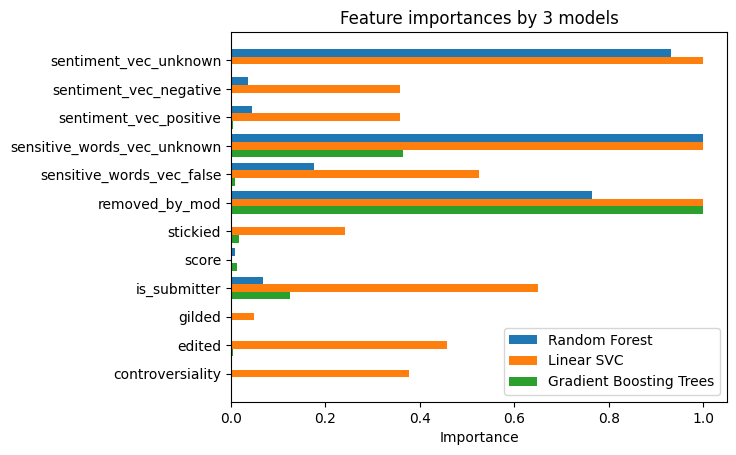

In [0]:
import matplotlib.pyplot as plt 

plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(features_actual))*1.5
rf_imp = list(scaled_importances["rf_imp"])
rf_imp.reverse()
svm_imp = list(scaled_importances["svm_imp"])
svm_imp.reverse()
gbt_imp = list(scaled_importances["gbt_imp"])
gbt_imp.reverse()
ax.barh(y_pos - 0.4, rf_imp, 0.4, align='center', label = 'Random Forest')
ax.barh(y_pos, svm_imp, 0.4, align='center', label = 'Linear SVC')
ax.barh(y_pos + 0.4, gbt_imp, 0.4, align='center', label = 'Gradient Boosting Trees')
ax.set_yticks(y_pos)
y_labels = features_actual
y_labels.reverse()
ax.set_yticklabels(y_labels)
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('Feature importances by 3 models')
ax.legend()
fpath = os.path.join(PLOT_DIR, "feature_importances.png")
plt.savefig(fpath)
plt.show()

This bar chart describes the relative importances of features utlized in the 3 machine learning models. The importances of Linear SVC model are the absolute values(there were negative contributions), and the importance values have been normalized into a range of [0,1]; we could observe the following findings:<br>
1. Regarding the overall distribution of the importances, we could see that Linear SVC has the most balanced scale of importances, followed by Random Forest; as for the Gradient Boosting Trees model of green bars, the importances seem to concentrate on a few features.<br>
2. Regarding the single features, we shall see that the unknown features(sentiment_vec_known, sensitive_words_vec_unknown) and removed_by_mod are generally having the largest importances in prediction. Since posts are tagged unknown in sentiment and sensitive words if and only if their body contents got removed by the moderators, these features all indicate that regulation of moderators could be a major factor in the cancellation of Reddit accounts, which seems reasonable since the sensitive words are usually offensive and moderators seem to have the power to directly cancel accounts posting too much inappropriate contents. <br>
3. As the main ways to measure the value of a post, score and gilded seem to have little importance in predicting account cancellation. This might comes from a fact that contents from a cancelled user usually receive low score(some even get negative scores!) and do not worth to be gilded at all.

### 5. Save and load the GBT model

In [0]:
import os

PLOT_DIR = os.path.join("..","..","data", "plots", "ml_analysis_2")
CSV_DIR = os.path.join("..","..","data", "csv", "ml_analysis_2")
fpath = os.path.join("..","ml_analysis_2","performances.csv")
print(CSV_DIR)

../../data/csv/ml_analysis_2


In [0]:
print(os.getcwd())

/Workspace/Repos/Project/fall-2022-reddit-big-data-project-project-group-21/code/ml


In [0]:
fpath = os.path.join("/Repos/Project/fall-2022-reddit-big-data-project-project-group-21/code/ml_analysis_2","gbt_pipeline")
model_gbt.write().overwrite().save(fpath)

In [0]:
import os
from pyspark.ml import PipelineModel

fpath = os.path.join("/Repos/Project/fall-2022-reddit-big-data-project-project-group-21/code/ml_analysis_2","gbt_pipeline")
gbt_model = PipelineModel.load(fpath)
prediction_from_file = gbt_model.transform(predict_data)
prediction_from_file.show()

+----------------+------+------+------------+-----+--------+--------------+---------------------------+---------------+-------+-------------+---------------+---------+-------------------+-------------+--------------------+--------------------+--------------------+----------+----------------------+
|controversiality|edited|gilded|is_submitter|score|stickied|removed_by_mod|contain_often_deleted_words|sentiment_class|deleted|delete_status|sensitive_words|sentiment|sensitive_words_vec|sentiment_vec|            features|       rawPrediction|         probability|prediction|predictedDeletedStatus|
+----------------+------+------+------------+-----+--------+--------------+---------------------------+---------------+-------+-------------+---------------+---------+-------------------+-------------+--------------------+--------------------+--------------------+----------+----------------------+
|               0| false|     0|       false|  -55|   false|         false|                      false|